In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-market-prediction/example_test.csv
/kaggle/input/jane-street-market-prediction/example_sample_submission.csv
/kaggle/input/jane-street-market-prediction/features.csv
/kaggle/input/jane-street-market-prediction/train.csv
/kaggle/input/jane-street-market-prediction/janestreet/__init__.py
/kaggle/input/jane-street-market-prediction/janestreet/competition.cpython-37m-x86_64-linux-gnu.so


In [4]:
import numpy as np
import pandas as pd 
import os


import warnings
warnings.filterwarnings("ignore")


In [5]:
from sklearn import preprocessing
import xgboost as xgb

print("XGBoost version:", xgb.__version__)

XGBoost version: 1.2.1


In [6]:
import janestreet
env = janestreet.make_env() # initialize the environment
iter_test = env.iter_test() # an iterator which loops over the test set

# Data loading

In [7]:
train = pd.read_csv('../input/jane-street-market-prediction/train.csv')
features = pd.read_csv('../input/jane-street-market-prediction/features.csv')
example_test = pd.read_csv('../input/jane-street-market-prediction/example_test.csv')
sample_prediction_df = pd.read_csv('../input/jane-street-market-prediction/example_sample_submission.csv')
print ("Data is loaded!")

Data is loaded!


In [8]:
print('train shape is {}'.format(train.shape))
print('features shape is {}'.format(features.shape))
print('example_test shape is {}'.format(example_test.shape))
print('sample_prediction_df shape is {}'.format(sample_prediction_df.shape))

train shape is (2390491, 138)
features shape is (130, 30)
example_test shape is (15219, 133)
sample_prediction_df shape is (15219, 2)


In [9]:
train.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,0,0.000000,0.009916,0.014079,0.008773,0.001390,0.006270,1,-1.872746,-2.191242,...,NaN,1.168391,8.313583,1.782433,14.018213,2.653056,12.600292,2.301488,11.445807,0
1,0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,-1,-1.349537,-1.704709,...,NaN,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,1
2,0,0.000000,0.025134,0.027607,0.033406,0.034380,0.023970,-1,0.812780,-0.256156,...,NaN,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299,2
3,0,0.000000,-0.004730,-0.003273,-0.000461,-0.000476,-0.003200,-1,1.174378,0.344640,...,NaN,2.838853,0.499251,3.033732,1.513488,4.397532,1.266037,3.856384,1.013469,3
4,0,0.138531,0.001252,0.002165,-0.001215,-0.006219,-0.002604,1,-3.172026,-3.093182,...,NaN,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,4


In [10]:

train = train[train['weight'] != 0]

train['action'] = ((train['weight'].values * train['resp'].values) > 0).astype('int')


X_train = train.loc[:, train.columns.str.contains('feature')]
y_train = train.loc[:, 'action']


In [11]:
X_train = X_train.fillna(-999)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report
from sklearn.model_selection import learning_curve,StratifiedKFold

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train,random_state=42)

# XGBoost Classifier

In [31]:
# The training part taked from here https://www.kaggle.com/xhlulu/ieee-fraud-xgboost-with-gpu-fit-in-40s

clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=11,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.7,
    missing=-999,
    random_state=2020,
    tree_method='gpu_hist'  # THE MAGICAL PARAMETER
)

In [32]:
%time clf.fit(X_train, y_train)

CPU times: user 1min 22s, sys: 3.22 s, total: 1min 25s
Wall time: 1min 26s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=-999,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              random_state=2020, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)

In [33]:
y_pred=clf.predict(X_test)

In [34]:
#Accuracy on test split
clf.score(X_test, y_test)

0.6136532259285616

In [35]:
#Accracy on train split
clf.score(X_train, y_train)

0.8379644788833517

In [36]:
target_names = ['Yes', 'No']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         Yes       0.62      0.59      0.60    196380
          No       0.61      0.64      0.63    199878

    accuracy                           0.61    396258
   macro avg       0.61      0.61      0.61    396258
weighted avg       0.61      0.61      0.61    396258



In [37]:
print('ROC-AUC:',round(roc_auc_score(y_test,y_pred),4))

ROC-AUC: 0.6134


Text(33.0, 0.5, 'Predicted Label')

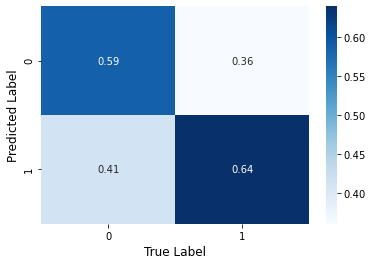

In [38]:
import seaborn as sns          
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label',size=12)
ax.set_ylabel('Predicted Label',size=12)

# **LogisticRegression**

In [14]:
clf = LogisticRegression(random_state=0,penalty='l2').fit(X_train, y_train)



In [15]:
y_pred=clf.predict(X_test)

In [16]:
#Accuracy on test split
clf.score(X_test, y_test)

0.5154772900484028

In [17]:
#Accracy on train split
clf.score(X_train, y_train)

0.5149811139102187

In [18]:
target_names = ['Yes', 'No']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         Yes       0.51      0.46      0.49    196380
          No       0.52      0.57      0.54    199878

    accuracy                           0.52    396258
   macro avg       0.52      0.51      0.51    396258
weighted avg       0.52      0.52      0.51    396258



In [19]:
print('ROC-AUC:',round(roc_auc_score(y_test,y_pred),4))

ROC-AUC: 0.515


Text(33.0, 0.5, 'Predicted Label')

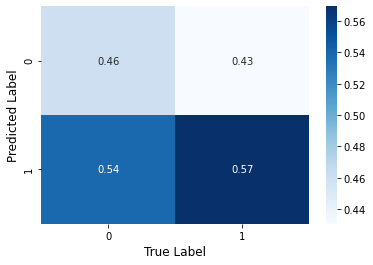

In [21]:
import seaborn as sns          
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label',size=12)
ax.set_ylabel('Predicted Label',size=12)

# Decision Tree Classifier

In [22]:
from sklearn import tree

In [23]:
clf = tree.DecisionTreeClassifier()

In [24]:
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [25]:
y_pred=clf.predict(X_test)

In [26]:
clf.score(X_test, y_test)

0.5646169919597838

In [27]:


clf.score(X_train, y_train)



1.0

In [28]:
target_names = ['Yes', 'No']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         Yes       0.56      0.56      0.56    196380
          No       0.57      0.57      0.57    199878

    accuracy                           0.56    396258
   macro avg       0.56      0.56      0.56    396258
weighted avg       0.56      0.56      0.56    396258



In [29]:
print('ROC-AUC:',round(roc_auc_score(y_test,y_pred),4))

ROC-AUC: 0.5646


Text(33.0, 0.5, 'Predicted Label')

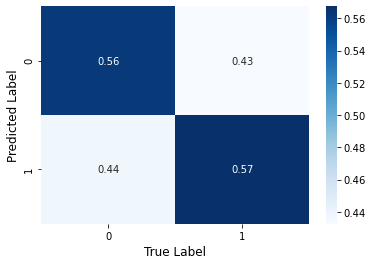

In [30]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label',size=12)
ax.set_ylabel('Predicted Label',size=12)